# BioSoc Bioinformatics Sessions: Analysis of Single-cell RNA data
### Pete Dockrill, Thursday 13th June 2024

In [1]:
## Uncomment following three lines to install the necessary R packages: 
#install.packages("ggplot2")
#install.packages("dplyr")
#install.packages('Seurat')

In [2]:
setwd("*insert your pwd*")

The data and much of the code for this tutorial is taken from the [Seurat PBMC introductory tutorial](https://satijalab.org/seurat/articles/pbmc3k_tutorial):

In [3]:
system("curl -O https://cf.10xgenomics.com/samples/cell/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz")

In [4]:
system("gzip -d pbmc3k_filtered_gene_bc_matrices.tar.gz")

In [5]:
system("tar -xf pbmc3k_filtered_gene_bc_matrices.tar")

In [6]:
library(dplyr)
library(Seurat)
library(patchwork)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t




## Introduction

### Genes and proteins

The nucleus of the cell contains the instructions necessary to make every protein in the human body in the form of ***DNA***. 

A (molecular) ***gene*** is defined as a section of ***DNA*** that has a particular function. Genes can either code for ***gene products*** (i.e ***proteins***) or can be involved in the regulation of other genes. 

Each gene is ***transcribed*** into an ***RNA transcript***, which is then translated into a polypeptide chain of ***amino acids*** by a ribosome. We call this process ***gene expression***. 

Cells can control the levels of gene expression through ***regulatory processes***, which can increase or decrease the amount of a specific protein in response to external or internal stimuli. 

### Example from the adaptive immune system

B lymphocytes (a.k.a B cells) are a type of white blood cell that protect the body from pathogens. They have proteins on their surface (***receptors***) that are able identify non-self proteins and activate the cells: 

<a title="Clarkdn (talk) (Uploads), CC0, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Bcellreceptor.svg"><img width="1200" alt="Bcellreceptor" src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/ee/Bcellreceptor.svg/128px-Bcellreceptor.svg.png?20140523073514"></a>

If a receptor recognises a non-self protein, it begins a process where certain genes are up-regulated or down-regulated in order to perform a particular task. 

If B cells are activated they start to produce ***antibodies*** - proteins which have an almost identical structure to B cell receptors and are designed to bind to pathogens, prevent infection and assist in the immune response. 

### Uniprot

Genes and their proteins can be found in online databases such as [Uniprot](https://www.uniprot.org), which provide almost all the information you could possibly need. 

Begin by typing a gene name into the home page search box:

<img src="Images/Uniprot_open.png" width="1200">

This will produce several results, most likely for several different organisms - you can select human-only proteins by clicking 'Human' under 'Popular organisms' in the side bar. 

<img src="Images/Uniprot_search.png" width="1200">

Clicking on an entry will give you all kinds of information:
* other names for the protein
* genomic coordinates (location on the genome)
* location in the cell (e.g cell membrane, nucleus, cytoplasm)
* role of the protein in disease
* common variants and their effects
* three-dimensional structure  

<img src="Images/Uniprot_result.png" width="1200">

## Data preparation 

### scRNA-seq data

In single-cell sequencing, we take the ***RNA transcripts*** from each individual cell (collectively known as the ***transcriptome***) and sequence it.

This allows us to see what decisions the cells are making - of all the available proteins that are encoded in the genome, which proteins are the cells actually producing and how does this vary across individual cells?

Data from single-cell sequencing experiements are generally placed in a matrix (i.e a table), where each row represents a cell (labelled by a cell ***barcode***) and each column represents a gene: 

In [7]:
# Load the PBMC dataset
pbmc.data <- Read10X(data.dir = "filtered_gene_bc_matrices/hg19/")
pbmc <- CreateSeuratObject(counts = pbmc.data, project = "pbmc3k", min.cells = 3, min.features = 200)
new_pbmc <- pbmc.data[c("PPBP", "LYZ","S100A9","IGLL5","GNLY","FTL","PF4","FTH1"),1:26] 
new_pbmc

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
  [[ suppressing 26 column names ‘AAACATACAACCAC-1’, ‘AAACATTGAGCTAC-1’, ‘AAACATTGATCAGC-1’ ... ]]



8 x 26 sparse Matrix of class "dgCMatrix"
                                                                           
PPBP    .  .  .  1  .  . . . .  .  . .  .  . . .  . .   . .  . . . .   .  .
LYZ     1  3  2 24  .  1 1 1 .  3  1 .  2 55 . 1 21 2  47 1  1 1 2 1  63  1
S100A9  .  .  . 12  .  . . . .  .  . .  . 34 1 . 20 .  26 .  . . . 1 143  .
IGLL5   .  .  .  .  .  . . . .  .  . .  .  . . .  . .   . .  . . . .   .  .
GNLY    .  .  1  .  3  . 5 . 1  .  . .  .  1 . .  . .   . 1  1 . 2 .   .  1
FTL    12 10  8 78 18 11 5 5 . 44  4 4  9 52 3 2 55 3 142 9 17 7 7 5 113 11
PF4     .  .  .  .  .  . . . .  .  . .  .  . . .  . .   . .  . . . .   .  .
FTH1    2 17 11 98  3  3 3 1 7 51 13 7 10 45 2 5 24 2 100 8 10 4 9 3  34  8

Each *element* of the matrix is the *expression level* of a gene by a cell, which describes the amount of ***RNA transcripts*** of a particular gene that is present in the ***transcriptome*** of an individual cell. Smaller numbers indicate that the cell isn't producing much of the gene product and larger numbers indicate that the cell is producing lots of the gene product.

### Normalising and filtering data  

Like any real-world data, datasets from sequencing experiments are often messy. We want to keep high quality reads and make sure that we're taking data from live cells.

One of the biggest issues is controlling the number of genes. Bad reads are often indicated by either i) small numbers of genes, which can indicate bad sequencing performance, and/or ii) extraordinarily large numbers of reads, which can indicate contamination from other cells and should be removed. Similarly, a high percentage of mitochondrial genes (i.e more than 5%) can indicate a dying cell, so these cells are often removed from the dataset. 

In [8]:
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")
pbmc <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)

To allow for each cell to be compared, the dataset also has to be normalised.

In [9]:
pbmc <- NormalizeData(pbmc)

Normalizing layer: counts



Note that this is somewhat of a tradeoff. Small or large numbers of genes can also indicate inactive or highly active cells, and large percentage of mitochondrial genes can indicate high levels of respiration which are common in particular populations of cells. These filtering conditions should therefore be chosen according to the hypotheses that are being addressed, otherwise you risk removing the very cells that you want to look at!

## Dimensionality reduction

### The curse of dimensionality

We are used to visualising things in two or three dimensions, where data points have two or three coordinates ($x$, $y$ and $z$) that represent their position in along each of the $x$, $y$ and $z$ axes: $$\textbf{x} = (x_1, x_2, x_3) = (x, y, z)$$

We can also go beyond three dimensions with more than three axes: $$\textbf{x} = (x_1, x_2, x_3, x_4, ..., x_N)$$

We can define a 'gene expression' space, where each axis represents the expression level of a particular gene and each data point corresponds to a single cell's expression level for each of these genes: $$\textbf{x} = (\text{expression of gene 1}, \text{expression of gene 2},...,\text{expression of gene N})$$ 

In single-cell RNA experiments we are working with data that has a huge number of dimensions (i.e $N$ is big). This is obviously a problem when it comes to visualising the data as we can't draw a graph in 13714 dimensions!

### Dimensionality reduction

It might be that only a handful of the genes present in the cells have expression values that differ by a significant amount. 

In this case, the variance displayed by a small subset of genes would contribute to the majority of the variance displayed by the overall dataset.

This means that we can mostly ignore the other genes without worrying too much about losing information, as the majority of the cells will have very similar expression values for each of these genes.

Furthermore, if we can find a way of reducing the data down to two or three dimensions, we can plot it on a graph and make some visual observations that might inform scientific hypotheses. 

We begin by finding the top 10 most variable features - the 10 genes that contribute most to the variance of the data:

In [10]:
pbmc <- FindVariableFeatures(pbmc, selection.method = "vst", nfeatures = 2000)
top10 <- head(VariableFeatures(pbmc), 10)
print(top10)

Finding variable features for layer counts



 [1] "PPBP"   "LYZ"    "S100A9" "IGLL5"  "GNLY"   "FTL"    "PF4"    "FTH1"  
 [9] "GNG11"  "S100A8"


Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


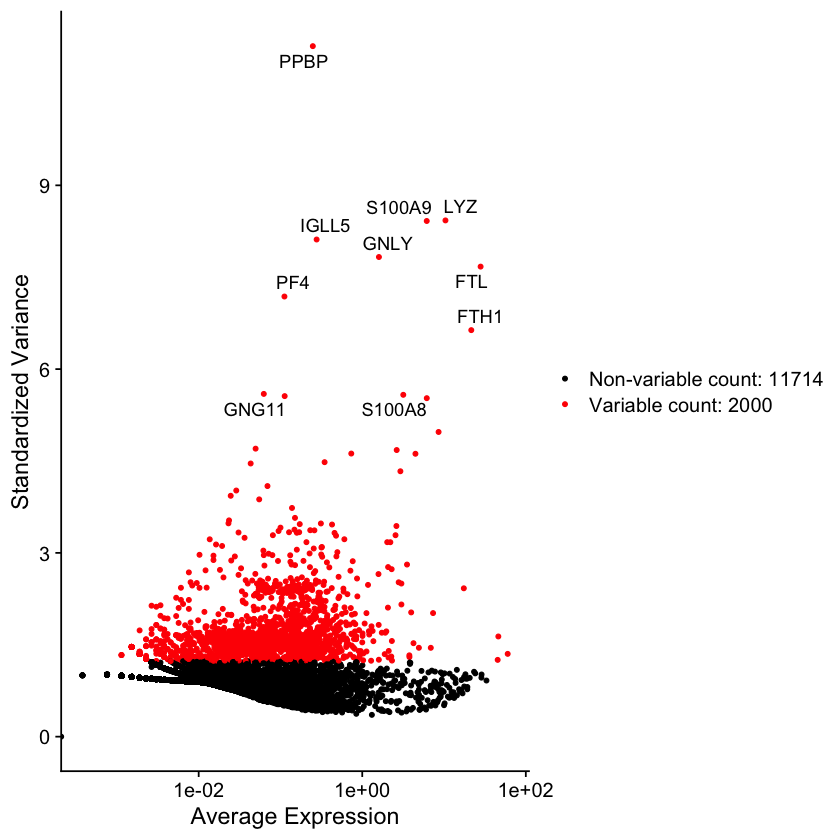

In [11]:
VFplot <- VariableFeaturePlot(pbmc)
VFplot <- LabelPoints(plot = VFplot, points = top10, repel = TRUE, xnudge = 0, ynudge = 0)
VFplot

We can then run a statistical process called Principal Component Analysis (PCA). This forms new axes by adding existing axes together:  

In [12]:
all.genes <- rownames(pbmc)
pbmc <- ScaleData(pbmc, features = all.genes)
pbmc <- RunPCA(pbmc, features = VariableFeatures(object = pbmc))

Centering and scaling data matrix

PC_ 1 
Positive:  CST3, TYROBP, LST1, AIF1, FTL, FTH1, LYZ, FCN1, S100A9, TYMP 
	   FCER1G, CFD, LGALS1, S100A8, CTSS, LGALS2, SERPINA1, IFITM3, SPI1, CFP 
	   PSAP, IFI30, SAT1, COTL1, S100A11, NPC2, GRN, LGALS3, GSTP1, PYCARD 
Negative:  MALAT1, LTB, IL32, IL7R, CD2, B2M, ACAP1, CD27, STK17A, CTSW 
	   CD247, GIMAP5, AQP3, CCL5, SELL, TRAF3IP3, GZMA, MAL, CST7, ITM2A 
	   MYC, GIMAP7, HOPX, BEX2, LDLRAP1, GZMK, ETS1, ZAP70, TNFAIP8, RIC3 
PC_ 2 
Positive:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DQB1, HLA-DRA, LINC00926, CD79B, HLA-DRB1, CD74 
	   HLA-DMA, HLA-DPB1, HLA-DQA2, CD37, HLA-DRB5, HLA-DMB, HLA-DPA1, FCRLA, HVCN1, LTB 
	   BLNK, P2RX5, IGLL5, IRF8, SWAP70, ARHGAP24, FCGR2B, SMIM14, PPP1R14A, C16orf74 
Negative:  NKG7, PRF1, CST7, GZMB, GZMA, FGFBP2, CTSW, GNLY, B2M, SPON2 
	   CCL4, GZMH, FCGR3A, CCL5, CD247, XCL2, CLIC3, AKR1C3, SRGN, HOPX 
	   TTC38, APMAP, CTSC, S100A4, IGFBP7, ANXA1, ID2, IL32, XCL1, RHOC 
PC_ 3 
Positive:  HLA-DQA1, CD79A,

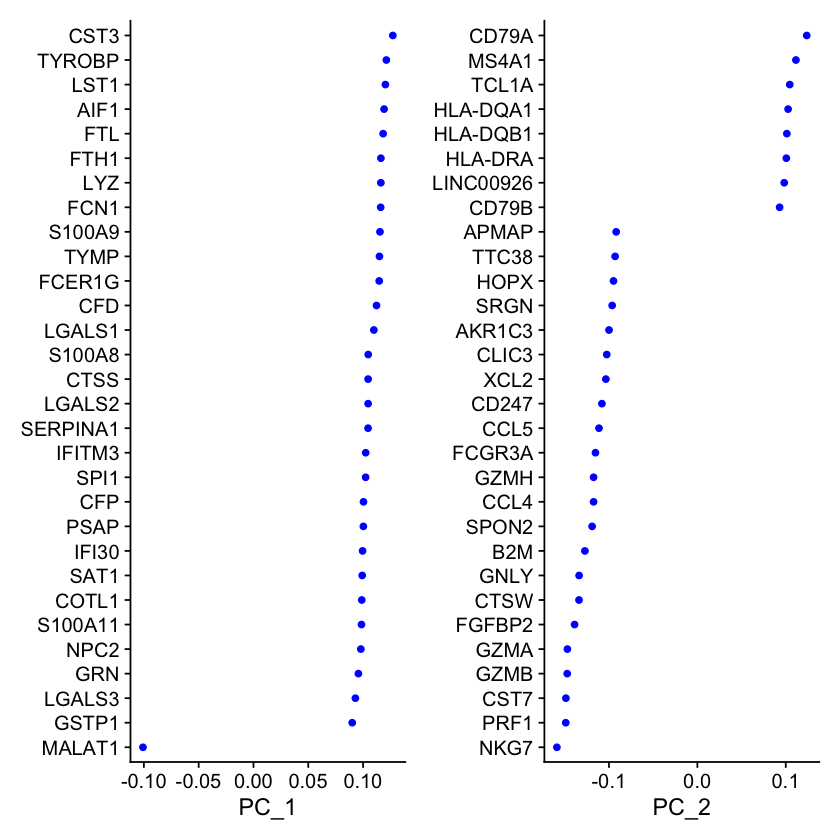

In [13]:
VizDimLoadings(pbmc, dims = 1:2, reduction = "pca")

For example, we can see that the first two principal components are combinations of the following genes: $$\text{PC1} = \alpha_1 \text{CST3} + \alpha_2 \text{TYROBP} + \alpha_3 \text{LST1} + ...$$
$$\text{PC2} = \beta_1 \text{CD79A} + \beta_2 \text{MS4A1} + \beta_3 \text{TCL1A} + ...$$ where $\alpha_i, \beta_i$ are numbers (coefficients) which describe how much each gene contributes to the new dimension and, by extension, to the overall statistical properties of the data.

This can tell us important information about the underlying dataset. For example, the gene [CD79A](https://www.uniprot.org/uniprotkb/P11912/entry) has a large contribution to the second principal component, $PC_2$ - this is a gene that codes for a protein that forms part of the B cell receptor, suggesting that the dataset could contain a large number of B cells.

Finally, this allows us to visualise the data in a way that we can see it in two dimensions.

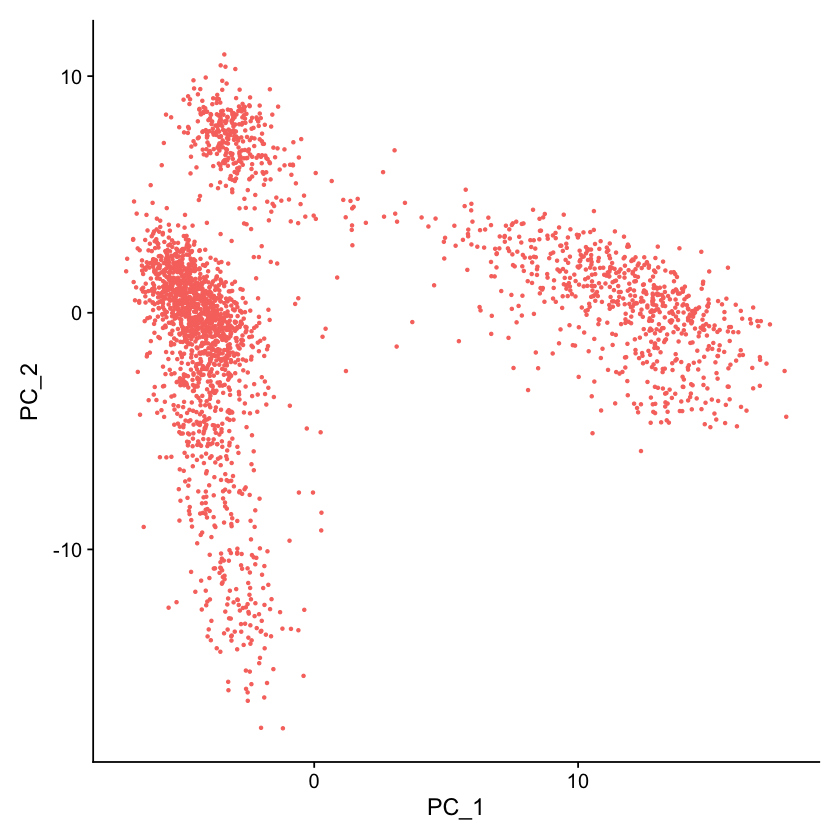

In [14]:
DimPlot(pbmc, reduction = "pca") + NoLegend()

## Tasks

### Main task

We have calculated the top 10 most variable genes in the dataset: PPBP, LYZ, S100A9, IGLL5, GNLY, FTL, PF4, FTH1, GNG11 and S100A8

For each of these genes, look at their [Uniprot](https://www.uniprot.org) entries and find the following information:
* the location of each gene in the genome (chromosome and position) 
* the roles of each gene/protein in healthy patients and diseased patients
* a common variant (might not be present for all genes)

Finally, use the information you have gathered to predict what kind of cells might present in the dataset and what biological processes were happening at the time of sequencing. 

### Extension tasks

Try to alter the code and re-run the cells above to answer the following questions:
* What are the top 15, 20 or 25 most variable genes? What are their gene products and what happens when variants occur in these genes?
* What genes are present in the 3rd, 4th and 5th principal components?
* What happens if you change the filtering conditions?
